In [1]:
# 필요한 라이브러리 및 모듈

import numpy as np
import cv2
import butter
from matplotlib import pyplot as plt

In [2]:
# 1. Read Video file

# generate video object
filename = "./input/original_video_SR30.mp4"
cap = cv2.VideoCapture(filename)

In [3]:
# 2. Gray Scale로 변환

# 첫번째 프레임 읽기
ret, frame = cap.read()

# 영상의 사이즈 확인
frame_size = frame.shape
print("Shape of image is : ",frame.shape)

# Gray Sacle 이미지로 변환
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
print("Shape of image is : ",gray.shape)

Shape of image is :  (256, 640, 3)
Shape of image is :  (256, 640)


### Histogram 과 CLAHE

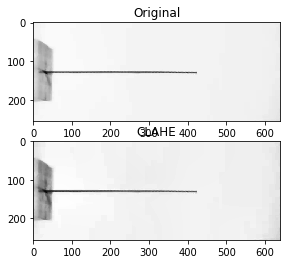

In [4]:
# contrast limit가 2이고 title의 size는 8X8
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
img2 = clahe.apply(gray)
plt.subplot(211),plt.imshow(gray, cmap = 'gray'),plt.title('Original')
plt.subplot(212),plt.imshow(img2, cmap = 'gray'),plt.title('CLAHE')
plt.show()

In [5]:
def CLAHE(input):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    output = clahe.apply(input)
    return output

### Gaussian pyramid
In a Gaussian pyramid, subsequent images are **weighted down using a Gaussian average (Gaussian blur) and scaled down.** Each pixel containing a local average corresponds to a neighborhood pixel on a lower level of the pyramid. This technique is used especially in texture synthesis.

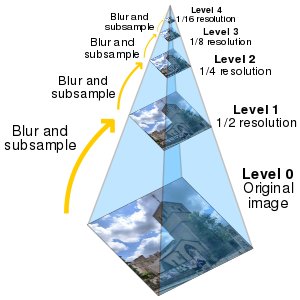

### Laplacian pyramid
A Laplacian pyramid is very similar to a Gaussian pyramid but saves the difference image of the blurred versions between each levels. Only the smallest level is not a difference image to enable reconstruction of the high resolution image using the difference images on higher levels. This technique can be used in image compression

__출처 : https://en.wikipedia.org/wiki/Pyramid_(image_processing)__

In [6]:
# pyramid 안쓰고, resize함수로 피라미드 정의

def pyramidDown(input):
    heigh, width = input.shape
    blur = cv2.GaussianBlur(input, (5,5), 0)
    output = cv2.resize(blur, None, fx = 0.5, fy = 0.5)
    return output

def pyramidUp(input):
    heigh, width = input.shape
    input = cv2.resize(input, None, fx = 2, fy = 2, interpolation = cv2.INTER_LINEAR)
    output = cv2.GaussianBlur(input, (5,5), 0)
    return output

In [7]:
# 3. Generate Pyramid
Gau_seq = [[],[],[],[],[],[],[]]
Lap_seq = [[],[],[],[],[],[],[]]

while ret:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = CLAHE(gray)
    
    # Normalize intensity
    gray = gray.astype('float64')
    gray = gray / 255
    
    Gau = [gray]
    Down = pyramidDown(gray)
    Gau.append(Down)

    for i in range (0,6):
        Down = pyramidDown(Down)
        Gau.append(Down)
    
    Gau_copy = []
    Gau_copy[:] = Gau
    Gau_copy.reverse()
    
    for i in range (0,7):
        Gau_seq[i].append(Gau_copy.pop())

    Lap = []
    for i in range (0, 7):
        Up = pyramidUp(Gau.pop())
        Lap.append(Gau[len(Gau)-1]-Up)

    #Lap.reverse()
    
    for i in range (0,7):
        Lap_seq[i].append(Lap.pop())
    ret, frame = cap.read()

In [8]:
# 4. 확대 주파수 결정 및 필터링
# Parameter Initializing 

SR = 2200 # SR is Sampling Rate
Fn = SR/2
T = 1/SR # T is Period
Low_freq = 350/2
High_freq = 370/2
alpha = 10

In [9]:
# 원하는 주파수 선택적으로 확대 
import time
start = time.time()
#f=open('python_bandpass.csv','a')

frame_size = Lap_seq[0][0].shape

# level 0
for i in range (0, frame_size[0]):
    for j in range (0, frame_size[1]):
        time_stack = []
        
        for k in range (0, 100):
            time_stack.append(Lap_seq[0][k][i][j])
            
        time_stack = butter.butter_bandpass_filter(time_stack, Low_freq, High_freq, SR, order=5)
        #np.savetxt(f, np.column_stack(time_stack), delimiter=",", fmt='%s',  newline='\n')
        for k in range (0, 100):
            Lap_seq[0][k][i][j] += alpha * time_stack[k]
            
end = time.time()
delay = end - start
print("1st level : ", delay)

1st level :  75.9697597026825


In [10]:
# level 1 
start = time.time()
test = Lap_seq[1][0].copy()
for i in range (0, Lap_seq[1][0].shape[0]):
    for j in range (0, Lap_seq[1][0].shape[1]):
        time_stack = []
        
        for k in range (0, 100):
            time_stack.append(Lap_seq[1][k][i][j])
            
        time_stack = butter.butter_bandpass_filter(time_stack, Low_freq, High_freq, SR, order=5)
        
        for k in range (0, 100):
            Lap_seq[1][k][i][j] += alpha * time_stack[k]
            
end = time.time()
delay = end - start
print("2nd level : ", delay)

2nd level :  17.556573152542114


In [11]:
# level 2
start = time.time()
for i in range (0, Lap_seq[2][0].shape[0]):
    for j in range (0, Lap_seq[2][0].shape[1]):
        time_stack = []
        
        for k in range (0, 100):
            time_stack.append(Lap_seq[2][k][i][j])
            
        time_stack = butter.butter_bandpass_filter(time_stack, Low_freq, High_freq, SR, order=5)
        
        for k in range (0, 100):
            Lap_seq[2][k][i][j] += time_stack[k]
            
end = time.time()
delay = end - start
print("3nd level : ", delay)

3nd level :  4.047192096710205


In [12]:
Rec2= []
for i in range (0, 100):
    Sum = Lap_seq[2][i] + Gau_seq[2][i]
    Rec2.append(Sum)

for i in range (0, 100):
    Rec2[i] = pyramidUp(Rec2[i])

Rec1 = []
for i in range (0, 100):
    Sum = Lap_seq[1][i] + Rec2[i]
    #Sum = Lap_seq[1][i] + Gau_seq[1][i]
    Rec1.append(Sum)
    
for i in range (0, 100):
    Rec1[i] = pyramidUp(Rec1[i])

Rec0 = []
for i in range (0, 100):
    Sum = Lap_seq[0][i]+ Rec1[i]
    Rec0.append(Sum)

In [13]:
# 형변환 및 오버플로우 방지

for i in range(0, 100):
    Rec0[i][Rec0[i]<0] = 0
    Rec0[i][Rec0[i]>1] = 1
    Rec0[i] *= 255
    Rec0[i] = Rec0[i].astype('uint8')

In [14]:
# Output 파일 생성 

size = Rec0[0].shape

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('./output/' + 'alpha_' + str(alpha) + 'output.mp4', fourcc, 30.0, (640, 256), isColor = False)

for i in range (0, len(Rec0)):
    out.write(Rec0[i])
    
out.release()

In [15]:
(Lap_seq[1][0]-test).max()

9.40695141227188e-09